In [1]:
import sys
sys.path.append("../")
import os
os.environ['NUMEXPR_MAX_THREADS'] = '32'

import numpy as np
import pandas as pd 
import json
import warnings
import datetime
from timeit import default_timer
from itertools import product
from scipy import stats
from scipy.special import inv_boxcox
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import spyt
from spyt import spark_session
import pyspark.sql.functions as F 
import pyspark.sql.types as T 
from pyspark.sql.functions import col, lit, broadcast
from clan_tools.secrets.Vault import Vault
from src.resources_overbooking.disk_capacity.kkr_nrd_forecast import load_data_kkr_nrd

def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape, axis=0)
    return np.average(output_errors)


Vault().get_secrets()
# from clan_tools.utils.spark import DEFAULT_SPARK_CONF
DEFAULT_SPARK_CONF = {
    "spark.executor.memory": "8G",
    "spark.executor.cores": 2,
    "spark.sql.session.timeZone": "UTC",
    "spark.dynamicAllocation.maxExecutors": 8,
    "spark.dynamicAllocation.enabled":True,
    "spark.sql.autoBroadcastJoinThreshold":-1,
    "spark.cores.min":16,
    "spark.driver.memory": "4G",
    "spark.executor.instances":6,
}

## Загрузка датафрейма

In [2]:
spark = spyt.connect(spark_conf_args=DEFAULT_SPARK_CONF)
spyt.info(spark)

2021-07-16 16:37:10,779 - spyt.client: [INFO]: SPYT Cluster version: 3.0.1-1.6.2+yandex
2021-07-16 16:37:10,782 - spyt.client: [INFO]: SPYT library version: 1.3.5


In [3]:
kkr_prod_path = "//home/cloud_analytics/dwh/ods/nbs/kikimr_disk_used_space"
kkr_preprod_path = "//home/cloud_analytics/dwh_preprod/ods/nbs/kikimr_disk_used_space"
nrd_prod_path = "//home/cloud_analytics/dwh/ods/nbs/nbs_nrd_used_space"

df = load_data_kkr_nrd(spark, kkr_prod_path=kkr_prod_path, kkr_preprod_path=kkr_preprod_path, 
                       nrd_prod_path=nrd_prod_path).toPandas()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['env', 'disk_type','datacenter','date']).reset_index(drop=True)

2021-07-16 16:37:10,952 - src.resources_overbooking.disk_capacity.kkr_nrd_forecast: [INFO]: Starting to load DataFrame


In [4]:
spyt.stop(spark)

In [5]:
# about dataframe
print('Shape:', df.shape)

print('Column "env":\n\t', 
      ', '.join([str(row[0])+':'+str(row[1][0]) 
                 for row in pd.DataFrame(df['env'].value_counts()).iterrows()]))

print('Column "disk_type":\n\t', 
      ', '.join([str(row[0])+':'+str(row[1][0]) 
                 for row in pd.DataFrame(df['disk_type'].value_counts()).iterrows()]))

print('Column "datacenter":\n\t', 
      ', '.join([str(row[0])+':'+str(row[1][0]) 
                 for row in pd.DataFrame(df['datacenter'].value_counts()).iterrows()]))

print('Column "date":\n\t', ("%d values from " % df['date'].nunique())+
      df['date'].min().strftime('%Y-%m-%d')+
      " to "+
      df['date'].max().strftime('%Y-%m-%d'))
df.head()

Shape: (8386, 7)
Column "env":
	 prod:4498, preprod:3888
Column "disk_type":
	 hdd:3834, ssd:3834, ssd_nrd:718
Column "datacenter":
	 all:2098, myt:2098, sas:2097, vla:2093
Column "date":
	 486 values from 2020-03-18 to 2021-07-16


,source,date,env,disk_type,datacenter,used_TB,total_TB
0,kikimr,2020-03-18,preprod,hdd,all,287.619861,2255.837800
1,kikimr,2020-03-19,preprod,hdd,all,287.429532,2255.837807
2,kikimr,2020-03-20,preprod,hdd,all,287.387267,2255.837807
3,kikimr,2020-03-21,preprod,hdd,all,284.266562,2255.837513
4,kikimr,2020-03-22,preprod,hdd,all,284.275566,2255.837507


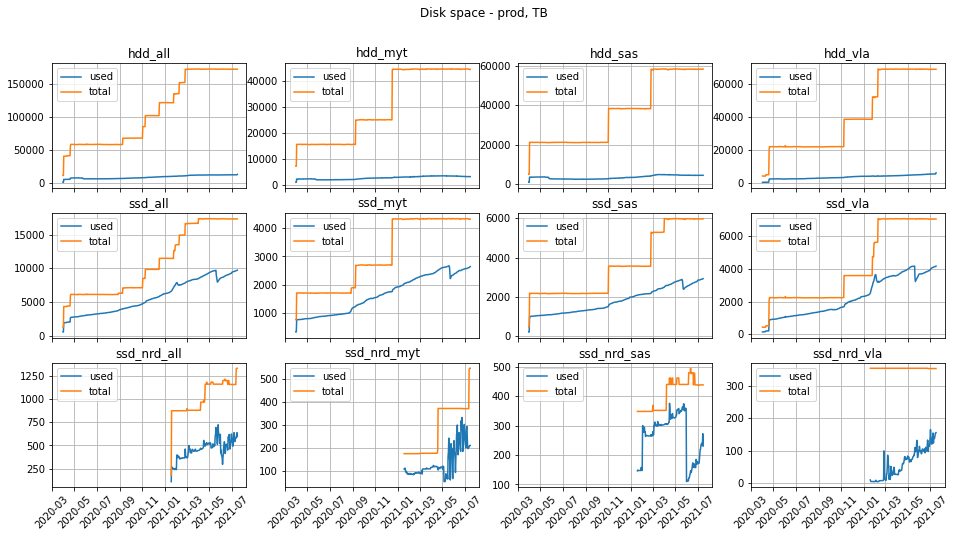

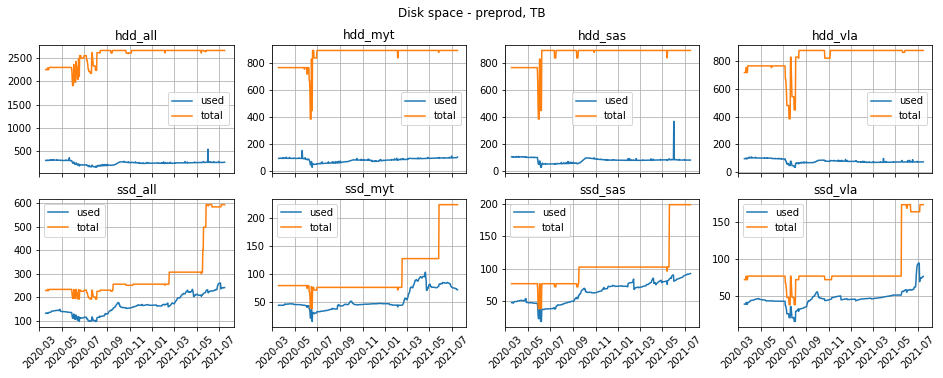

In [6]:
for env in ['prod', 'preprod']:
    df_temp = df[df['env']==env]
    fig_shape = df_temp['disk_type'].nunique(), df_temp['datacenter'].nunique()
    plt.subplots(*fig_shape, sharex=True, figsize=(16,fig_shape[0]*2.6))
    plt.suptitle(f'Disk space - {env}, TB')
    for i, dtp in enumerate(df_temp['disk_type'].unique()):
        for j, dtc in enumerate(df_temp['datacenter'].unique()):
            ax = plt.subplot(*fig_shape, i*fig_shape[1]+j+1)
            plt.title(f'{dtp}_{dtc}')
            tmp = df_temp[(df_temp['disk_type']==dtp) & (df_temp['datacenter']==dtc)]
            plt.plot(tmp['date'], tmp['used_TB'], label='used')
            plt.plot(tmp['date'], tmp['total_TB'], label='total')
            plt.xlim(left=pd.to_datetime('2020-03-01'))
            plt.grid()
            plt.legend()
            plt.xticks(rotation=45)
    plt.show()
del df_temp

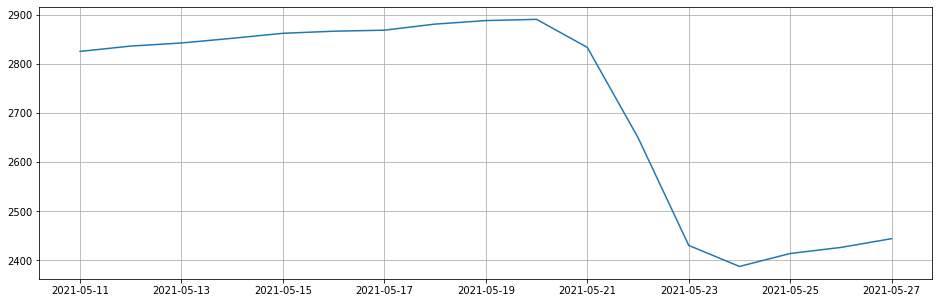

In [7]:
plt.figure(figsize=(16,5))

df_temp = df[(df['env']=='prod') & 
             (df['disk_type']=='ssd') & 
             (df['datacenter']=='sas')]
df_temp = df_temp[(df_temp['date']>pd.to_datetime('2021-05-10')) & 
                  (df_temp['date']<pd.to_datetime('2021-05-28'))]

plt.plot(df_temp['date'], df_temp['used_TB'])

plt.grid()
plt.show()

del df_temp

In [8]:
from_date = {}
from_date[('prod', 'hdd', 'all')] = '2020-06-01'
from_date[('prod', 'hdd', 'vla')] = '2020-06-01'
from_date[('prod', 'hdd', 'myt')] = '2020-06-01'
from_date[('prod', 'hdd', 'sas')] = '2020-06-01'

from_date[('prod', 'ssd', 'all')] = '2020-04-20'
from_date[('prod', 'ssd', 'vla')] = '2020-04-20'
from_date[('prod', 'ssd', 'myt')] = '2020-04-15'
from_date[('prod', 'ssd', 'sas')] = '2020-04-15'

from_date[('prod', 'ssd_nrd', 'all')] = '2021-03-10'
from_date[('prod', 'ssd_nrd', 'vla')] = '2021-03-10'
from_date[('prod', 'ssd_nrd', 'myt')] = '2021-03-10'
from_date[('prod', 'ssd_nrd', 'sas')] = '2021-03-10'

from_date[('preprod', 'hdd', 'all')] = '2020-08-05'
from_date[('preprod', 'hdd', 'vla')] = '2020-08-05'
from_date[('preprod', 'hdd', 'myt')] = '2020-07-01'
from_date[('preprod', 'hdd', 'sas')] = '2020-07-01'

from_date[('preprod', 'ssd', 'all')] = '2020-07-01'
from_date[('preprod', 'ssd', 'vla')] = '2020-10-15'
from_date[('preprod', 'ssd', 'myt')] = '2020-07-01'
from_date[('preprod', 'ssd', 'sas')] = '2020-07-01'

In [9]:
ignore_periods = {}
# format - list of dicts with names: 'from_date', 'num_days', 'comment'

ignore_periods[('prod', 'hdd', 'all')] = []
ignore_periods[('prod', 'hdd', 'vla')] = []
ignore_periods[('prod', 'hdd', 'myt')] = []
ignore_periods[('prod', 'hdd', 'sas')] = []

event_defr = {'from_date': '2021-05-18', 
              'num_days': 7, 
              'comment': "Дефрагментация"}
event_defr_vla = {'from_date': '2021-02-01', 
                  'num_days': 7, 
                  'comment': "Дефрагментация (VLA)"}
event_kasp_vla = {'from_date': '2021-01-18', 
                  'num_days': 7, 
                  'comment': "Касперский +200ТБ"}
ignore_periods[('prod', 'ssd', 'all')] = [event_kasp_vla, event_defr_vla, event_defr]
ignore_periods[('prod', 'ssd', 'vla')] = [event_kasp_vla, event_defr_vla, event_defr]
ignore_periods[('prod', 'ssd', 'myt')] = [event_defr]
ignore_periods[('prod', 'ssd', 'sas')] = [event_defr]

ignore_periods[('prod', 'ssd_nrd', 'all')] = []
ignore_periods[('prod', 'ssd_nrd', 'vla')] = []
ignore_periods[('prod', 'ssd_nrd', 'myt')] = []
ignore_periods[('prod', 'ssd_nrd', 'sas')] = []

ignore_periods[('preprod', 'hdd', 'all')] = []
ignore_periods[('preprod', 'hdd', 'vla')] = []
ignore_periods[('preprod', 'hdd', 'myt')] = []
ignore_periods[('preprod', 'hdd', 'sas')] = []

ignore_periods[('preprod', 'ssd', 'all')] = []
ignore_periods[('preprod', 'ssd', 'vla')] = []
ignore_periods[('preprod', 'ssd', 'myt')] = []
ignore_periods[('preprod', 'ssd', 'sas')] = []
   

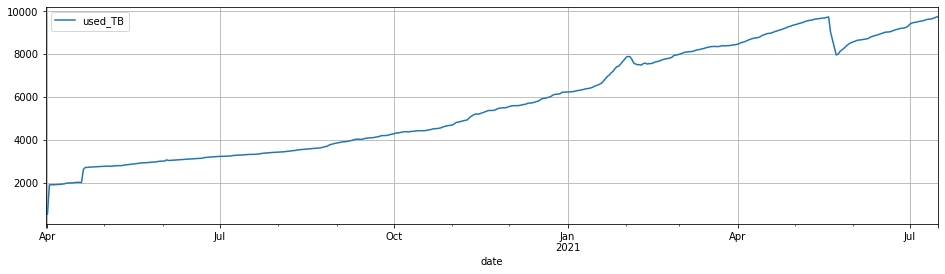

In [10]:
dts_temp = df[(df['env']=='prod') & (df['disk_type']=='ssd') & (df['datacenter']=='all')]\
            .set_index('date')[['used_TB']].resample('D').max().ffill()
dts_temp.plot(figsize=(16,4))
plt.grid()
plt.show()

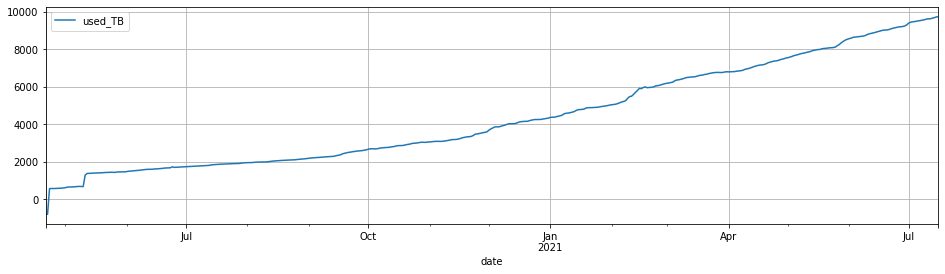

In [11]:
def transform_ignore(df, ignore_periods=[], date_col=None):
    if not bool(ignore_periods):
        return df
    df = df.copy()
    if bool(date_col):
        df = df.set_index(date_col)
    for event in ignore_periods:
        start_ = pd.to_datetime(event['from_date'])
        days_delta_ = datetime.timedelta(days=event['num_days'])
        end_ = start_ + days_delta_
        delta_ = df.loc[end_] - df.loc[start_]
        df_start_ = df[df.index<start_] + delta_
        df_start_.index = df_start_.index + days_delta_
        df_end_ = df[df.index>=end_]
        df =  pd.concat([df_start_, df_end_], axis=0)
    if bool(date_col):
        df = df.reset_index()
    return df
    

transform_ignore(dts_temp, ignore_periods[('prod', 'ssd', 'all')]).plot(figsize=(16,4))
plt.grid()
plt.show()

## Sarimax 

### Декомпозия временных рядов

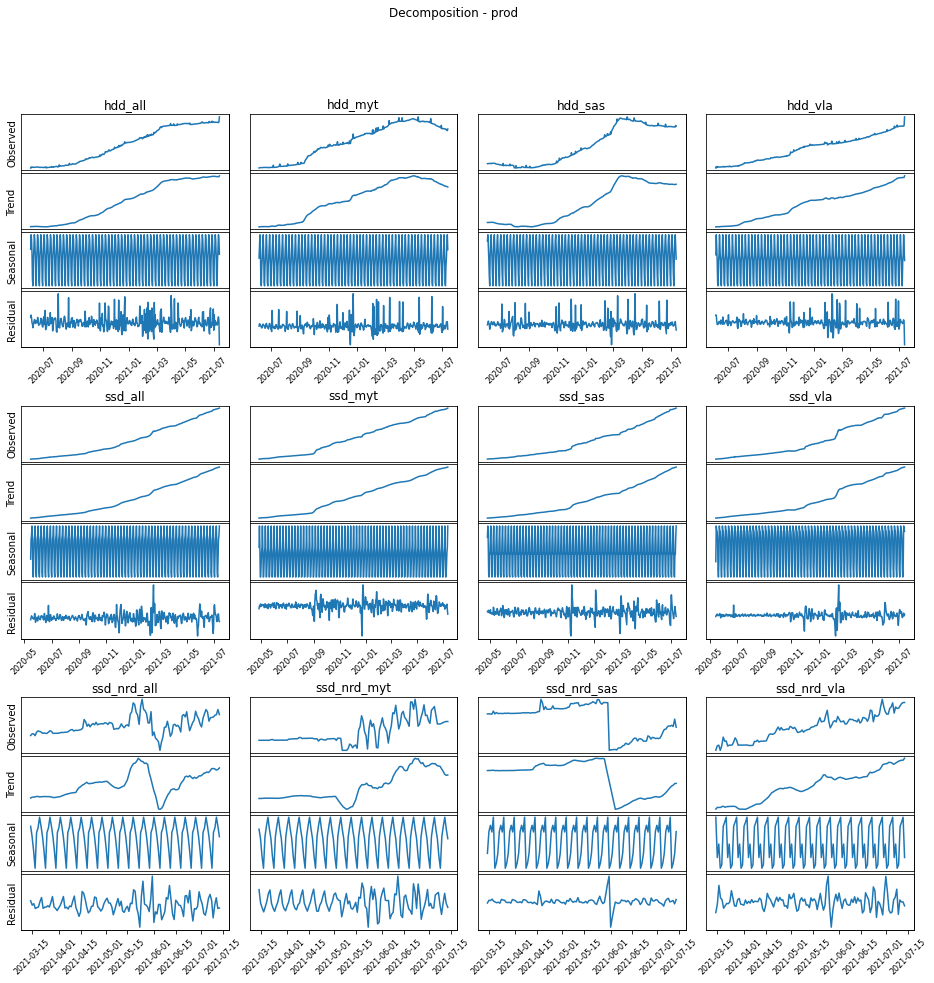

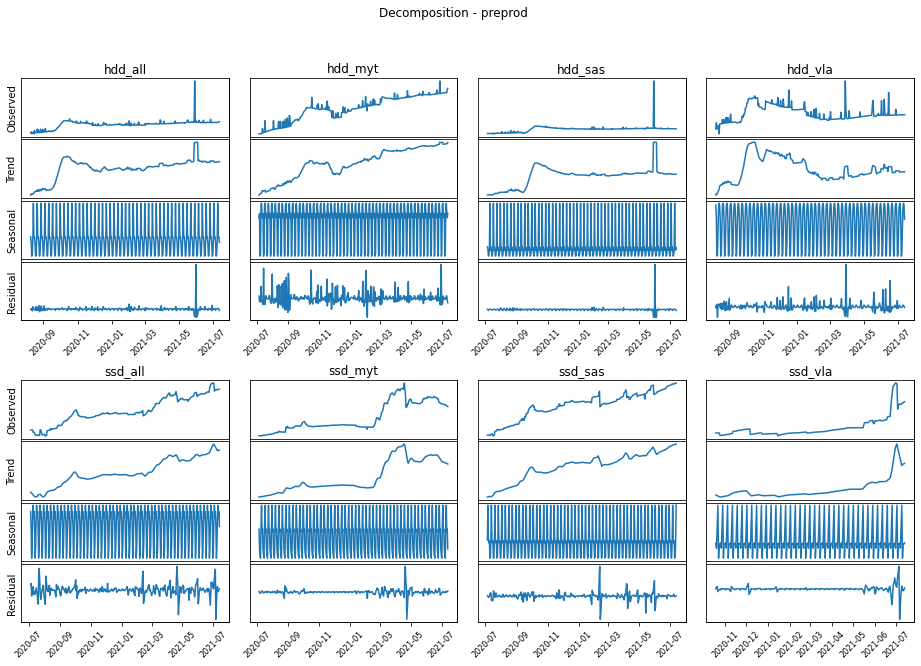

In [12]:
# decomposition of all combinations of disk_type/datacenter
def plotseasonal_partial(res, axes, plot_label=False):
    def inner_plot(num, series, name, plot_xticks=False, plot_ylabel=plot_label,):
        axes[num].plot(series.index, series)
        if plot_ylabel:
            axes[num].set_ylabel(name)
        axes[num].set_yticks([])
        if not plot_xticks:
            axes[num].set_xticks([])
        else:
            axes[num].tick_params(axis='x', rotation=45, labelsize=8)
            
    inner_plot(0, res.observed, 'Observed')
    inner_plot(1, res.trend, 'Trend')
    inner_plot(2, res.seasonal, 'Seasonal')
    inner_plot(3, res.resid, 'Residual', True)

    for ax in axes:
        fig.add_subplot(ax)

all_dts = {}
for env in ['prod', 'preprod']:
    df_temp = df[df['env']==env]
    fig_shape = [df_temp['disk_type'].nunique(), df_temp['datacenter'].nunique()]
    fig = plt.figure(figsize=(16, fig_shape[0]*5))
    plt.suptitle(f'Decomposition - {env}')
    outer = gridspec.GridSpec(*fig_shape, wspace=0.1, hspace=0.25)
    
    all_dts[env] = {}
    for i, dtp in enumerate(df_temp['disk_type'].unique()):
        all_dts[env][dtp] = {}
        for j, dtc in enumerate(df_temp['datacenter'].unique()):
            fig.add_subplot(outer[i*fig_shape[1]+j])
            dts_temp = df_temp[(df_temp['disk_type']==dtp) & (df_temp['datacenter']==dtc)]\
                            .set_index('date')[['used_TB']]\
                            .resample('D')\
                            .max()\
                            .ffill()
            dts_temp = dts_temp[dts_temp.index>pd.to_datetime(from_date[(env, dtp, dtc)])]
            dts_temp = transform_ignore(dts_temp, ignore_periods[(env, dtp, dtc)])
            all_dts[env][dtp][dtc] = {'general': dts_temp}
            all_dts[env][dtp][dtc].update({'ignore_period': ignore_periods[(env, dtp, dtc)]})
            plt.title(f'{dtp}_{dtc}') 
            plt.xticks([])
            plt.yticks([])
            inner = gridspec.GridSpecFromSubplotSpec(nrows=4, ncols=1,
                            subplot_spec=outer[i*fig_shape[1]+j], wspace=0.05, hspace=0.05)
            try:
                res = sm.tsa.seasonal_decompose(dts_temp['used_TB'])
                axes = [plt.Subplot(fig, inner[k]) for k in range(4)]
                plotseasonal_partial(res, axes, j==0)
            except ValueError:
                pass
    fig.show()
    
del df_temp

### Data split

In [13]:
for env in ['prod', 'preprod']:
    df_temp = df[df['env']==env]
    for dtp in df_temp['disk_type'].unique():
        for dtc in df_temp['datacenter'].unique():
            general = all_dts[env][dtp][dtc]['general'][['used_TB']]
            if (general.shape[0] != 0):
                train = general[:-min(90, len(general)*3//10)]
                valid = general[-min(90, len(general)*3//10):]
    #             test  = general[-min(50, len(general)*3//20):]
                print(env, dtp, dtc, '-', len(train), len(valid))
                crit_df = sm.tsa.stattools.adfuller(general)[1]
                all_dts[env][dtp][dtc].update({'train'  : train, 
                                          'valid'  : valid, 
    #                                       'test'   : test, 
                                          'params' : {'DF-test':crit_df,
                                                      'from_date':from_date[(env, dtp, dtc)]}})
del df_temp

prod hdd all - 320 90
prod hdd myt - 320 90
prod hdd sas - 320 90
prod hdd vla - 320 90
prod ssd all - 341 90
prod ssd myt - 360 90
prod ssd sas - 360 90
prod ssd vla - 341 90
prod ssd_nrd all - 90 38
prod ssd_nrd myt - 90 38
prod ssd_nrd sas - 90 38
prod ssd_nrd vla - 90 38
preprod hdd all - 255 90
preprod hdd myt - 290 90
preprod hdd sas - 290 90
preprod hdd vla - 255 90
preprod ssd all - 290 90
preprod ssd myt - 290 90
preprod ssd sas - 290 90
preprod ssd vla - 192 82


### Стабилизация дисперсии

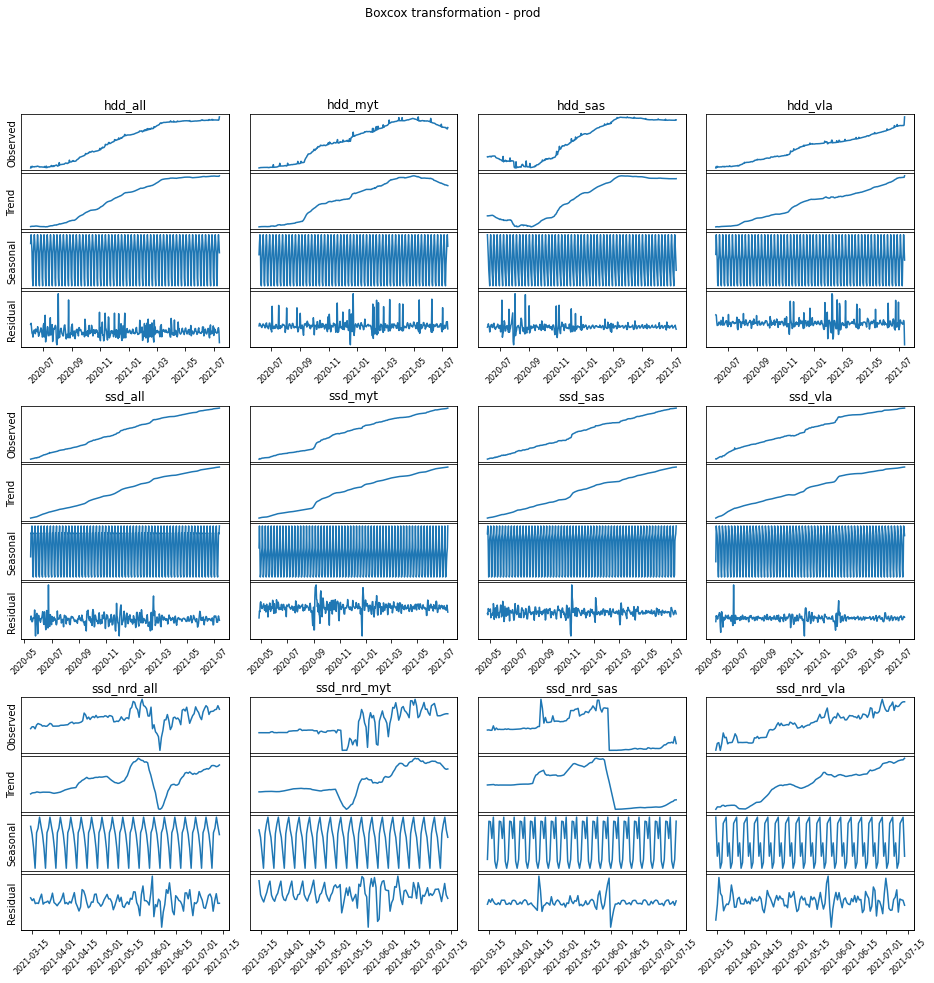

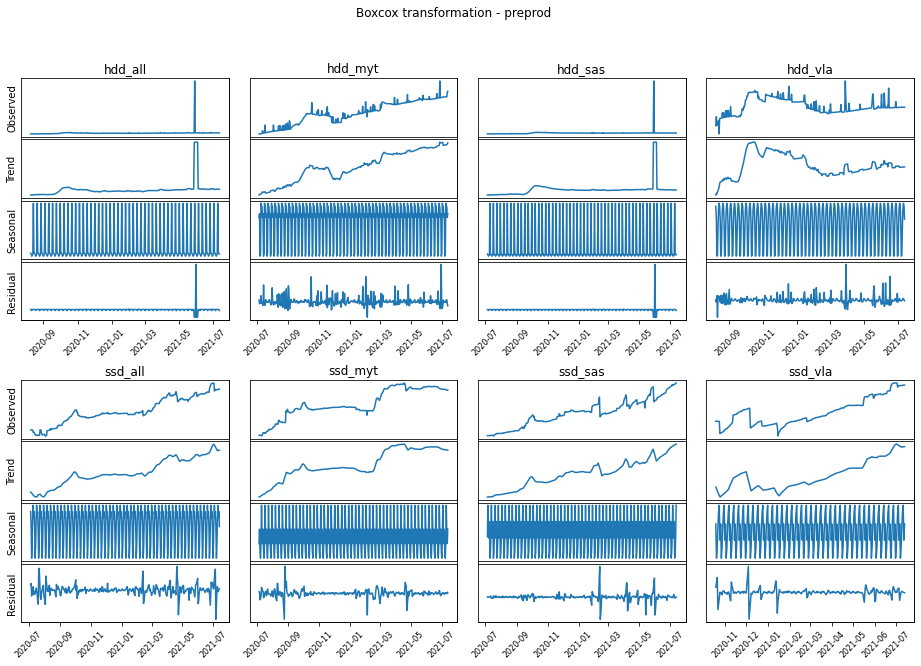

In [14]:
target_col = 'used_TB'
def add_boxcox_ts(df, lmbda, col=target_col):
    df = df.copy()
    df[col+'_box'] = stats.boxcox(df[col], lmbda=lmbda)
    return df

for env in ['prod', 'preprod']:
    df_temp = df[df['env']==env]
    for dtp in df_temp['disk_type'].unique():
        for dtc in df_temp['datacenter'].unique():
            if (all_dts[env][dtp][dtc]['general'].shape[0] != 0):
                _, lmbda = stats.boxcox(all_dts[env][dtp][dtc]['train'][target_col])
                lmbda = min(max(lmbda,-5),5)
                all_dts[env][dtp][dtc]['general'] = add_boxcox_ts(all_dts[env][dtp][dtc]['general'], lmbda)
                all_dts[env][dtp][dtc]['train'] = add_boxcox_ts(all_dts[env][dtp][dtc]['train'], lmbda)
                all_dts[env][dtp][dtc]['valid'] = add_boxcox_ts(all_dts[env][dtp][dtc]['valid'], lmbda)
#                 all_dts[env][dtp][dtc]['test'] = add_boxcox_ts(all_dts[env][dtp][dtc]['test'], lmbda)
                all_dts[env][dtp][dtc]['params']['boxcox'] = lmbda
                crit_df = sm.tsa.stattools.adfuller(all_dts[env][dtp][dtc]['general'][target_col+'_box'])[1]
                all_dts[env][dtp][dtc]['params']['DF-test_box'] = crit_df
del df_temp

for env in ['prod', 'preprod']:
    df_temp = df[df['env']==env]
    fig_shape = [df_temp['disk_type'].nunique(), df_temp['datacenter'].nunique()]
    fig = plt.figure(figsize=(16, fig_shape[0]*5))
    plt.suptitle(f'Boxcox transformation - {env}')
    outer = gridspec.GridSpec(*fig_shape, wspace=0.1, hspace=0.25)
    for i, dtp in enumerate(df_temp['disk_type'].unique()):
        for j, dtc in enumerate(df_temp['datacenter'].unique()):
            fig.add_subplot(outer[i*fig_shape[1]+j])
            if (all_dts[env][dtp][dtc]['general'].shape[0] != 0):
                dts_temp = all_dts[env][dtp][dtc]['general']
                plt.title(f'{dtp}_{dtc}') 
                plt.xticks([])
                plt.yticks([])
                inner = gridspec.GridSpecFromSubplotSpec(nrows=4, ncols=1,
                                subplot_spec=outer[i*fig_shape[1]+j], wspace=0.05, hspace=0.05)
                res = sm.tsa.seasonal_decompose(dts_temp[target_col+'_box'])
                axes = [plt.Subplot(fig, inner[k]) for k in range(4)]
                plotseasonal_partial(res, axes, j==0)
    fig.show()
del df_temp

### Стационарность

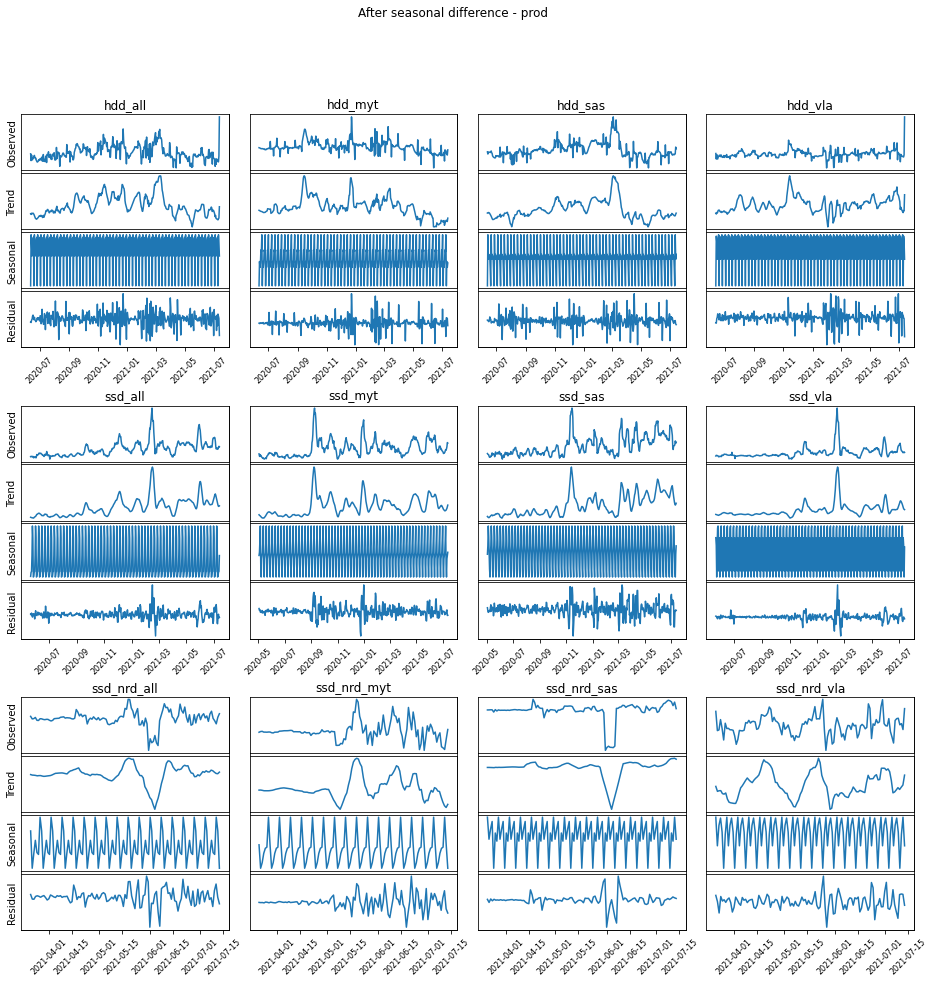

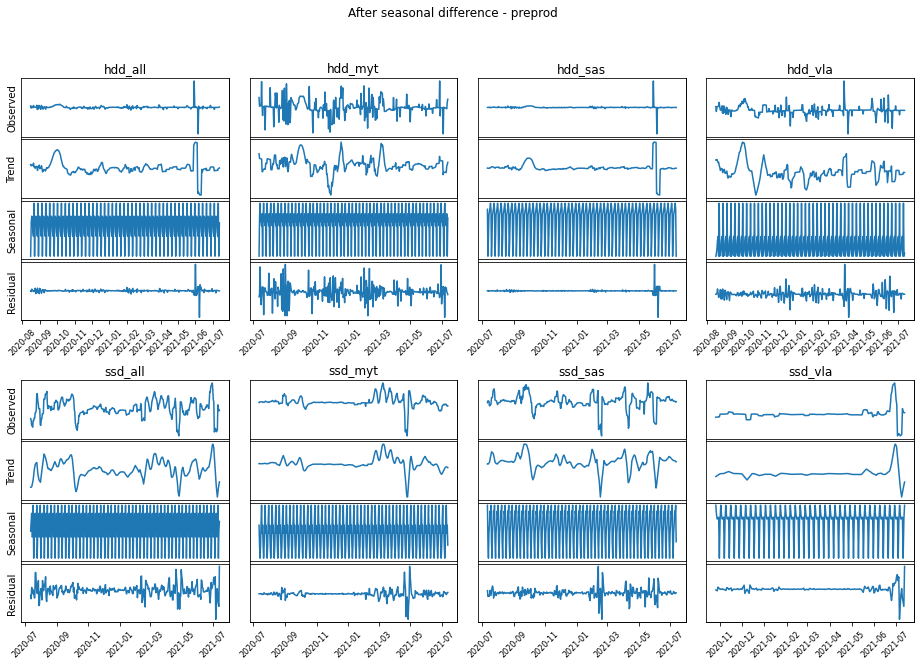

In [15]:
season_comp = True
col_to_work = target_col # + '_box'

def add_season_diff_ts(df, col=col_to_work, S=7):
    df = df.copy()
    if season_comp:
        df[col+'_sdiff'] = df[col].diff(S)
    else:
        df[col+'_sdiff'] = df[col]
    return df

for env in ['prod', 'preprod']:
    df_temp = df[df['env']==env]
    for dtp in df_temp['disk_type'].unique():
        for dtc in df_temp['datacenter'].unique():
            if (all_dts[env][dtp][dtc]['general'].shape[0] != 0):
                all_dts[env][dtp][dtc]['general'] = add_season_diff_ts(all_dts[env][dtp][dtc]['general'])
                all_dts[env][dtp][dtc]['train'] = add_season_diff_ts(all_dts[env][dtp][dtc]['train'])
                all_dts[env][dtp][dtc]['valid'] = add_season_diff_ts(all_dts[env][dtp][dtc]['valid'])
    #             all_dts[env][dtp][dtc]['test'] = add_season_diff_ts(all_dts[env][dtp][dtc]['test'])
                all_dts[env][dtp][dtc]['params']['S'] = 7 if season_comp else 0
                all_dts[env][dtp][dtc]['params']['D'] = 1 if season_comp else 0
                crit_df = sm.tsa.stattools.adfuller(all_dts[env][dtp][dtc]
                                                    ['general'][col_to_work+'_sdiff'].dropna())[1]
                all_dts[env][dtp][dtc]['params'].update({'DF-test_sdiff':crit_df, 
                                                         'work_col':col_to_work})
del df_temp


for env in ['prod', 'preprod']:
    df_temp = df[df['env']==env]
    fig_shape = [df_temp['disk_type'].nunique(), df_temp['datacenter'].nunique()]
    fig = plt.figure(figsize=(16, fig_shape[0]*5))
    plt.suptitle(f'After seasonal difference - {env}')
    outer = gridspec.GridSpec(*fig_shape, wspace=0.1, hspace=0.25)
    for i, dtp in enumerate(df_temp['disk_type'].unique()):
        for j, dtc in enumerate(df_temp['datacenter'].unique()):
            fig.add_subplot(outer[i*fig_shape[1]+j])
            if (all_dts[env][dtp][dtc]['general'].shape[0] != 0):
                dts_temp = all_dts[env][dtp][dtc]['general']
                plt.title(f'{dtp}_{dtc}') 
                plt.xticks([])
                plt.yticks([])
                inner = gridspec.GridSpecFromSubplotSpec(nrows=4, ncols=1,
                                subplot_spec=outer[i*fig_shape[1]+j], wspace=0.05, hspace=0.05)
                res = sm.tsa.seasonal_decompose(dts_temp[col_to_work+'_sdiff'].dropna())
                axes = [plt.Subplot(fig, inner[k]) for k in range(4)]
                plotseasonal_partial(res, axes, j==0)
    fig.show()
del df_temp

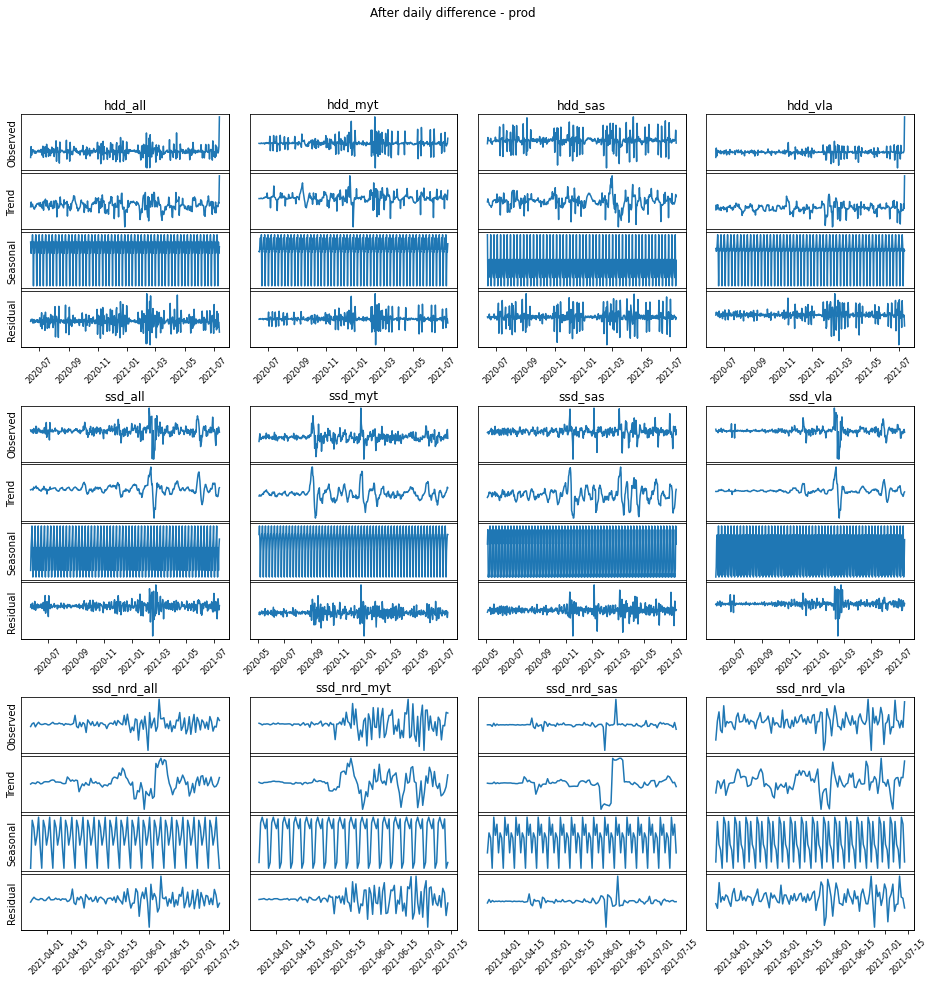

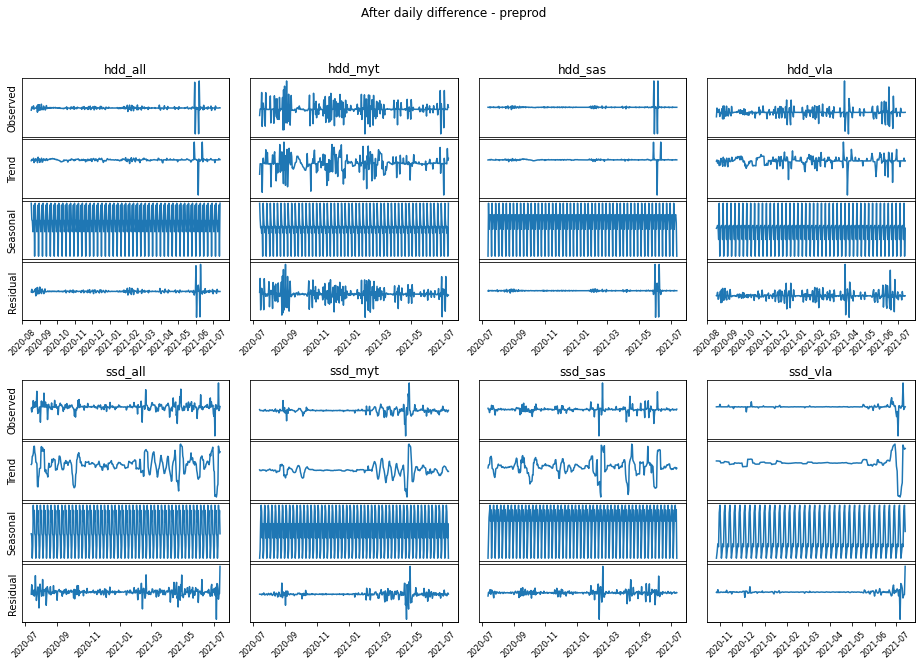

In [16]:
def add_simple_diff_ts(df, col='used_TB_sdiff'):
    df[col.replace('_sdiff','')+'_diff'] = df[col].diff()
    return df

for env in ['prod', 'preprod']:
    df_temp = df[df['env']==env]
    for dtp in df_temp['disk_type'].unique():
        for dtc in df_temp['datacenter'].unique():
            if (all_dts[env][dtp][dtc]['general'].shape[0] != 0):
                all_dts[env][dtp][dtc]['general'] = add_simple_diff_ts(all_dts[env][dtp][dtc]['general'])
                all_dts[env][dtp][dtc]['train'] = add_simple_diff_ts(all_dts[env][dtp][dtc]['train'])
                all_dts[env][dtp][dtc]['valid'] = add_simple_diff_ts(all_dts[env][dtp][dtc]['valid'])
    #             all_dts[env][dtp][dtc]['test'] = add_simple_diff_ts(all_dts[env][dtp][dtc]['test'])
                all_dts[env][dtp][dtc]['params']['d'] = 1
                crit_df = sm.tsa.stattools.adfuller(all_dts[env][dtp][dtc]
                                                    ['general'][col_to_work+'_diff'].dropna())[1]
                all_dts[env][dtp][dtc]['params'].update({'DF-test_diff':crit_df})
del df_temp


for env in ['prod', 'preprod']:
    df_temp = df[df['env']==env]
    fig_shape = [df_temp['disk_type'].nunique(), df_temp['datacenter'].nunique()]
    fig = plt.figure(figsize=(16, fig_shape[0]*5))
    plt.suptitle(f'After daily difference - {env}')
    outer = gridspec.GridSpec(*fig_shape, wspace=0.1, hspace=0.25)
    for i, dtp in enumerate(df_temp['disk_type'].unique()):
        for j, dtc in enumerate(df_temp['datacenter'].unique()):
            fig.add_subplot(outer[i*fig_shape[1]+j])
            if (all_dts[env][dtp][dtc]['general'].shape[0] != 0):
                dts_temp = all_dts[env][dtp][dtc]['general']
                plt.title(f'{dtp}_{dtc}') 
                plt.xticks([])
                plt.yticks([])
                inner = gridspec.GridSpecFromSubplotSpec(nrows=4, ncols=1,
                                subplot_spec=outer[i*fig_shape[1]+j], wspace=0.05, hspace=0.05)
                res = sm.tsa.seasonal_decompose(dts_temp[col_to_work+'_diff'].dropna())
                axes = [plt.Subplot(fig, inner[k]) for k in range(4)]
                plotseasonal_partial(res, axes, j==0)
    fig.show()
del df_temp

### Подбор моделей

In [17]:
# universal parameters list
ps = np.arange(6)
qs = np.arange(6)
Ps = np.array([0])
Qs = np.array([0])
Ss = np.array([0])
trs = np.array(['c','t'])
parameters_0 = product(ps, qs, Ps, Qs, Ss, trs)

ps = np.arange(6)
qs = np.arange(6)
Ps = np.arange(2)
Qs = np.arange(2)
Ss = np.array([7])
trs = np.array(['c','t'])
parameters_7 = product(ps, qs, Ps, Qs, Ss, trs)


parameters_list = list(parameters_0)+list(parameters_7)
len(parameters_list)

360

In [18]:
decision_metric = 'AIC'

warnings.filterwarnings('ignore')
def sarimax_fit(env, dtp, dtc, parameters_list, verbose=False, decision_metric=decision_metric):
    global all_dts
    dts_train = all_dts[env][dtp][dtc]['train'][all_dts[env][dtp][dtc]['params']['work_col']]
    dts_valid = all_dts[env][dtp][dtc]['valid'][all_dts[env][dtp][dtc]['params']['work_col']]
#     dts_test = all_dts[env][dtp][dtc]['test'][all_dts[env][dtp][dtc]['params']['work_col']]
    results = []

#     print(f'[{env}, {dtp}, {dtc}]:')
    t0 = default_timer()
    for param in tqdm(parameters_list, postfix='Work on: [%s]' % ', '.join([env, dtp, dtc])):
#     for param in parameters_list:
        if (env == 'prod') and (dtp == 'ssd_nrd') and (dtc == 'sas') and (param[5] == 't'):
            continue
        if (env == 'prod') and (dtp == 'ssd_nrd') and (param[4] == 7):
            continue
        if (env == 'prod') and (dtp == 'ssd_nrd') and ((param[0] > 2) or (param[1] > 2)):
            continue
        if (env == 'prod') and (dtp == 'hdd') and ((param[4] == 7)):
            continue
        if (env == 'prod') and (dtp == 'hdd') and ((param[0] > 0) or (param[1] > 1)):
            continue
        if (env == 'prod') and (dtp == 'ssd') and (param[5] == 't'):
            continue
        if (env == 'preprod') and (param[4] == 7):
            continue
        if (env == 'preprod') and (dtp == 'ssd') and (param[5] == 't'):
            continue
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(dts_train, 
                                            order=(param[0], # p
                                                   all_dts[env][dtp][dtc]['params']['d'], # d
                                                   param[1]), # q
                                            seasonal_order=(param[2], # P
                                                            int(param[4] != 0), # D
                                                            param[3], # Q
                                                            param[4]), # S
                                            trend=param[5]).fit(disp=-1)
            assert all(model.predict().notna())
        except Exception:
            if verbose:
                print('Error!\tWrong parameters:', param)
            continue

        # Результаты модели
        try:
            aic = model.aic # The Akaike information criterion
            mse_train = model.mse # mse train
            mae_train = model.mae # mae train
            mape_train = mean_absolute_percentage_error(dts_train, model.predict()) # mape train
            R2_train = r2_score(dts_train, model.predict()) # R_squared train
            forecast_valid = model.get_forecast(dts_valid.index[-1]).summary_frame()
            mse_valid = mean_squared_error(dts_valid, forecast_valid['mean']) # mse valid
            mae_valid = mean_absolute_error(dts_valid, forecast_valid['mean']) # mae valid
            mape_valid = mean_absolute_percentage_error(dts_valid, forecast_valid['mean']) # mape valid
            R2_valid = r2_score(dts_valid, forecast_valid['mean']) # R_squared valid
#             forecast_test = model.get_forecast(dts_test.index[-1]).summary_frame()[forecast_valid.shape[0]:]
#             mse_test = mean_squared_error(dts_test, forecast_test['mean']) # mse test
#             mae_test = mean_absolute_error(dts_test, forecast_test['mean']) # mae test
#             mape_test = mean_absolute_percentage_error(dts_test, forecast_test['mean']) # mape test
#             R2_test = r2_score(dts_test, forecast_test['mean']) # R_squared test
            results.append([param, aic, 
                            mse_train, mae_train, mape_train, R2_train, 
                            mse_valid, mae_valid, mape_valid, R2_valid, 
#                             mse_test, mae_test, mape_test, R2_test
                           ])
        except:
            print('New type Error:', param)
            continue
    t = default_timer() - t0
#     print('%d min %d sec\n' % (t//60, t%60))

    cols = ['params', 'AIC', 'mse_train', 'mae_train', 'mape_train', 'R2_train', 
            'mse_valid', 'mae_valid', 'mape_valid', 'R2_valid', 
#             'mse_test', 'mae_test', 'mape_test', 'R2_test'
           ]
    results = pd.DataFrame(results, columns=cols)
    all_dts[env][dtp][dtc]['results'] = results
    to_save = dict(results.loc[results[decision_metric].idxmin()])
    all_dts[env][dtp][dtc]['params']['p'] = int(to_save['params'][0])
    all_dts[env][dtp][dtc]['params']['q'] = int(to_save['params'][1])
    all_dts[env][dtp][dtc]['params']['P'] = int(to_save['params'][2])
    all_dts[env][dtp][dtc]['params']['Q'] = int(to_save['params'][3])
    all_dts[env][dtp][dtc]['params']['D'] = int(to_save['params'][4] != 0)
    all_dts[env][dtp][dtc]['params']['S'] = int(to_save['params'][4])
    all_dts[env][dtp][dtc]['params']['trend'] = to_save['params'][5]
    best_model = sm.tsa.statespace.SARIMAX(dts_train, 
                                           order=(all_dts[env][dtp][dtc]['params']['p'], # p
                                                  all_dts[env][dtp][dtc]['params']['d'], # d
                                                  all_dts[env][dtp][dtc]['params']['q']), # q
                                           seasonal_order=(all_dts[env][dtp][dtc]['params']['P'], # P
                                                           all_dts[env][dtp][dtc]['params']['D'], # D
                                                           all_dts[env][dtp][dtc]['params']['Q'], # Q
                                                           all_dts[env][dtp][dtc]['params']['S']), # S
                                           trend=all_dts[env][dtp][dtc]['params']['trend']).fit(disp=-1)
    all_dts[env][dtp][dtc]['best_model'] = best_model

for env in ['prod', 'preprod']:
    df_temp = df[df['env']==env]
    for dtp, dtc in product(df_temp['disk_type'].unique(), df_temp['datacenter'].unique()):
        if (all_dts[env][dtp][dtc]['general'].shape[0] != 0):
            sarimax_fit(env, dtp, dtc, parameters_list, verbose=True)
del df_temp

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [prod, hdd, all]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [prod, hdd, myt]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [prod, hdd, sas]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [prod, hdd, vla]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [prod, ssd, all]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [prod, ssd, myt]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [prod, ssd, sas]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [prod, ssd, vla]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [prod, ssd_nrd, all]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [prod, ssd_nrd, myt]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [prod, ssd_nrd, sas]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [prod, ssd_nrd, vla]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [preprod, hdd, all]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [preprod, hdd, myt]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [preprod, hdd, sas]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [preprod, hdd, vla]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [preprod, ssd, all]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [preprod, ssd, myt]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [preprod, ssd, sas]]

  0%|          | 0/360 [00:00<?, ?it/s, Work on: [preprod, ssd, vla]]

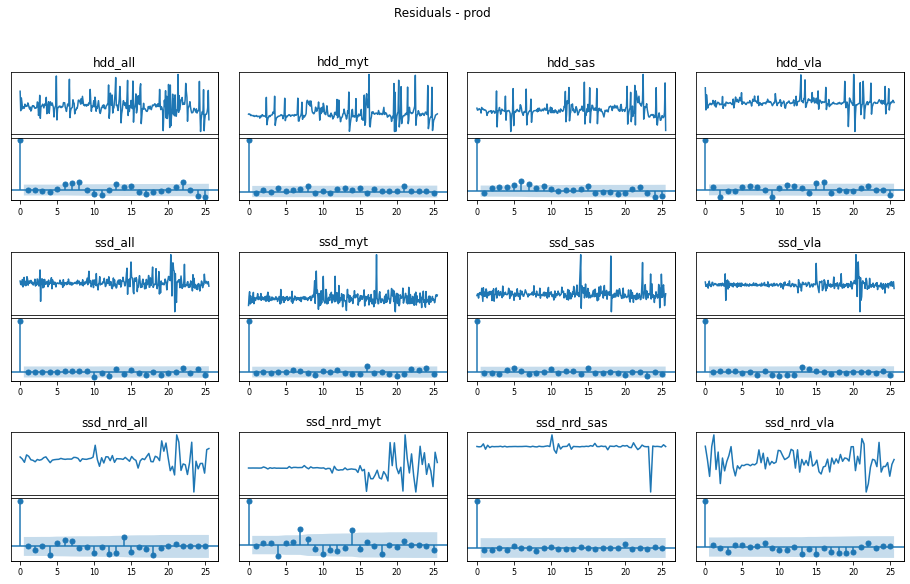

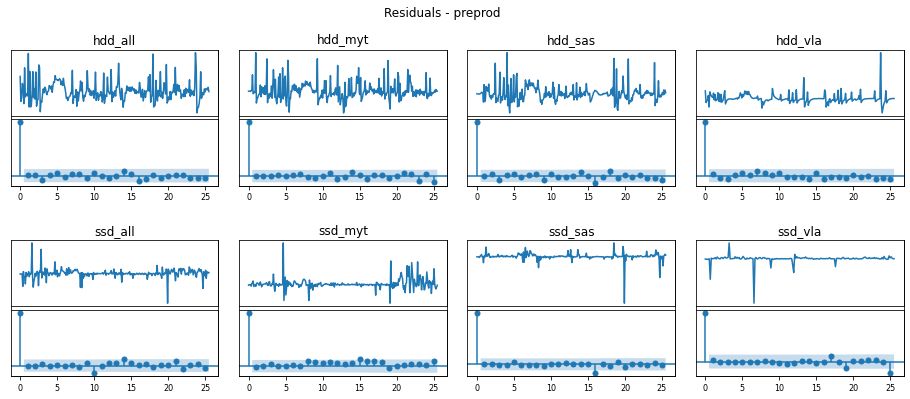

In [19]:
for env in ['prod', 'preprod']:
    df_temp = df[df['env']==env]
    fig_shape = [df_temp['disk_type'].nunique(), df_temp['datacenter'].nunique()]
    fig = plt.figure(figsize=(16, fig_shape[0]*3))
    plt.suptitle(f'Residuals - {env}')
    outer = gridspec.GridSpec(*fig_shape, wspace=0.1, hspace=0.4)
    for i, dtp in enumerate(df_temp['disk_type'].unique()):
        for j, dtc in enumerate(df_temp['datacenter'].unique()):
            fig.add_subplot(outer[i*fig_shape[1]+j])
            plt.title(f'{dtp}_{dtc}') 
            if (all_dts[env][dtp][dtc]['general'].shape[0] != 0):
                plt.xticks([])
                plt.yticks([])
                S = all_dts[env][dtp][dtc]['params']['S']
                residuals = all_dts[env][dtp][dtc]['best_model'].resid[S+1:]
                inner = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=1,
                                subplot_spec=outer[i*fig_shape[1]+j], wspace=0.05, hspace=0.05)
                ax0 = plt.Subplot(fig, inner[0])
                ax0.plot(residuals.index, residuals)
                ax0.set_xticks([])
                ax0.set_yticks([])
                fig.add_subplot(ax0)
                ax1 = plt.Subplot(fig, inner[1])
                sm.graphics.tsa.plot_acf(residuals.values, lags=25, ax=ax1)
                ax1.set_title('')
                ax1.set_yticks([])
                ax1.tick_params(axis='x', labelsize=8)
                fig.add_subplot(ax1)
    fig.show()
del df_temp

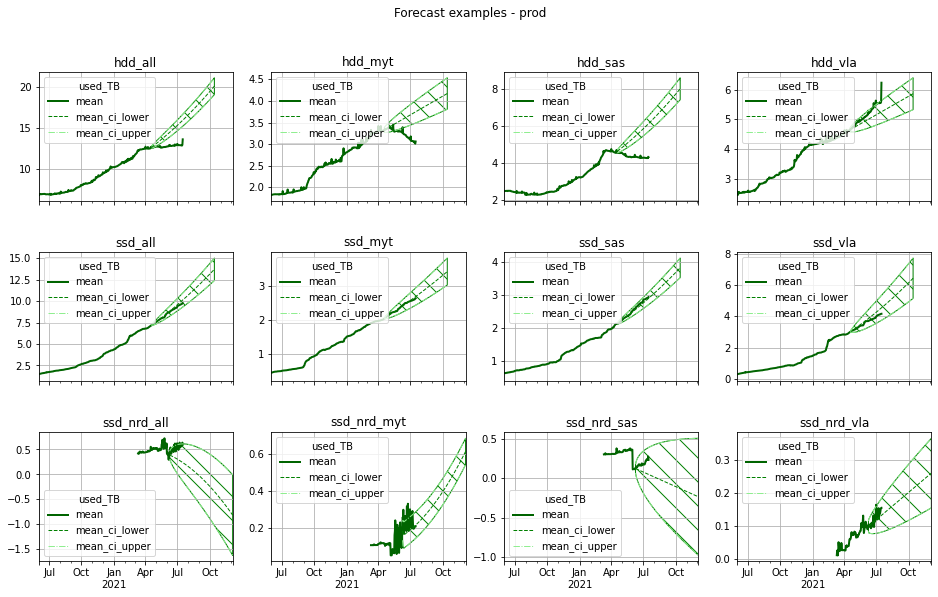

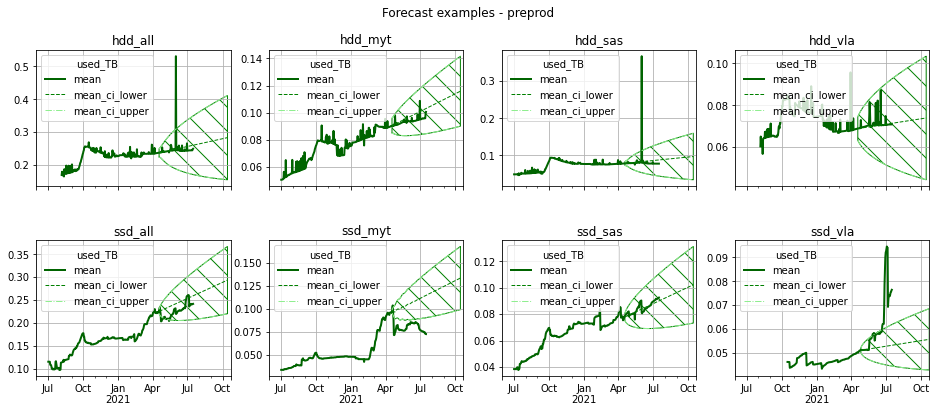

In [20]:
for env in ['prod', 'preprod']:
    df_temp = df[df['env']==env]
    fig_shape = [df_temp['disk_type'].nunique(), df_temp['datacenter'].nunique()]
    fig, ax = plt.subplots(*fig_shape, 
                           sharex=True,
                           gridspec_kw={'wspace':0.2, 'hspace':0.4}, 
                           figsize=(16, fig_shape[0]*3))
    plt.suptitle(f'Forecast examples - {env}')
    for i, dtp in enumerate(df_temp['disk_type'].unique()):
        for j, dtc in enumerate(df_temp['datacenter'].unique()):
            ax = plt.subplot(*fig_shape, i*fig_shape[1]+j+1)
            plt.title(f'{dtp}_{dtc}') 
            if (all_dts[env][dtp][dtc]['general'].shape[0] != 0):
                S = all_dts[env][dtp][dtc]['params']['S']
                (all_dts[env][dtp][dtc]['general']['used_TB']/1000).plot(ax=ax, c='darkgreen', lw=2)
                upper_ = (all_dts[env][dtp][dtc]['general']['used_TB']/1000).max()*3
                future = all_dts[env][dtp][dtc]['train'].index[-1] + datetime.timedelta(days=180)
                if (col_to_work == target_col+'_box'):
                    tt = (inv_boxcox(all_dts[env][dtp][dtc]['best_model'].get_forecast(future).summary_frame(), 
                                    all_dts[env][dtp][dtc]['params']['boxcox'])/1000).clip(upper=upper_)
                elif (col_to_work == target_col):
                    tt = (all_dts[env][dtp][dtc]['best_model']\
                          .get_forecast(future).summary_frame()/1000).clip(upper=upper_)
                else:
                    raise ValueError(f'Parameter col_to_work has value "{col_to_work}". '+
                                     f'It must "{target_col}" or "{target_col}_box"')
                tt[['mean']].plot(ax=ax, c='g', lw=1, ls='--')
                tt[['mean_ci_lower', 'mean_ci_upper']].plot(ax=ax, c='lightgreen', lw=1, ls='-.')
                plt.fill_between(tt.index, tt['mean_ci_upper'].fillna(upper_), tt['mean_ci_lower'].fillna(0), 
                                 hatch='\\', color="none", edgecolor='g')
                plt.xlabel('')
                plt.xlim(left=pd.to_datetime('2020-06-01'))
                plt.grid()
    fig.show()
del df_temp

In [21]:
res = pd.DataFrame()
colnames = ['env', 'disk_type', 'datacenter', 'p', 'd', 'q', 'P', 'D', 'Q', 'S', 'trend']
for env in ['prod', 'preprod']:
    df_temp = df[df['env']==env]
    for dtp, dtc in product(df_temp['disk_type'].unique(), df_temp['datacenter'].unique()):
        if (all_dts[env][dtp][dtc]['general'].shape[0] != 0):
            key = (all_dts[env][dtp][dtc]['params']['p'], all_dts[env][dtp][dtc]['params']['q'], 
                   all_dts[env][dtp][dtc]['params']['P'], all_dts[env][dtp][dtc]['params']['Q'], 
                   all_dts[env][dtp][dtc]['params']['S'], all_dts[env][dtp][dtc]['params']['trend'])
            t = pd.DataFrame([[env, dtp, dtc, key[0], all_dts[env][dtp][dtc]['params']['d'], key[1],
                               key[2], all_dts[env][dtp][dtc]['params']['D'], key[3], key[4], key[5]]], 
                             columns=colnames)
            results = all_dts[env][dtp][dtc]['results']
            results = results[results['params']==key].drop(columns=['params'])
            results.index = [0]
            t = pd.concat([t, results], axis=1)
            res = pd.concat([res, t], ignore_index=True)
del df_temp
display(res)

,env,disk_type,datacenter,p,d,q,P,D,Q,S,trend,AIC,mse_train,mae_train,mape_train,R2_train,mse_valid,mae_valid,mape_valid,R2_valid
0,prod,hdd,all,0,1,1,0,0,0,0,t,3555.683549,147927.277608,63.159695,0.007586,0.961052,2.851542e+06,1452.085186,0.113208,-133.947349
1,prod,hdd,myt,0,1,1,0,0,0,0,c,3067.752418,11225.182888,23.782390,0.010310,0.955844,1.362054e+05,289.896470,0.091694,-10.155080
2,prod,hdd,sas,0,1,1,0,0,0,0,t,3156.078063,20454.323602,28.464510,0.009692,0.967897,1.225719e+06,976.117438,0.225942,-128.712538
3,prod,hdd,vla,0,1,1,0,0,0,0,c,3149.149415,20147.260157,25.676743,0.008085,0.959253,5.846557e+04,194.201572,0.036300,0.383580
4,prod,ssd,all,5,1,2,0,1,1,7,c,2800.097905,7183.777759,15.879004,0.007346,0.997738,2.469797e+04,115.232197,0.012768,0.958094
5,prod,ssd,myt,5,1,2,0,1,1,7,c,2154.647973,542.371118,4.844341,0.007602,0.998177,6.109467e+02,19.564104,0.008145,0.979744
6,prod,ssd,sas,0,1,2,0,1,1,7,c,2298.512640,1156.671729,6.041829,0.007460,0.994599,1.854221e+03,34.149569,0.012731,0.970350
7,prod,ssd,vla,5,1,3,0,1,1,7,c,2669.197612,402.347562,7.823676,0.011003,0.999431,3.531679e+04,153.112597,0.040301,0.704292
8,prod,ssd_nrd,all,0,1,1,0,0,0,0,t,915.465678,3545.000321,28.026249,0.057434,0.339563,5.915544e+04,224.554179,0.400494,-16.768643
9,prod,ssd_nrd,myt,2,1,1,0,0,0,0,t,844.577238,796.647706,15.311260,0.150823,0.468774,5.023013e+03,54.814800,0.205005,-1.841376


In [22]:
config_params = {}
for env in ['prod', 'preprod']:
    df_temp = df[df['env']==env]
    config_params[env] = {}
    for dtp in df_temp['disk_type'].unique():
        config_params[env][dtp] = {}
        for dtc in df_temp['datacenter'].unique():
            sarimax_params = all_dts[env][dtp][dtc]['params'].copy()
            from_date = all_dts[env][dtp][dtc]['params']['from_date']
            del sarimax_params['DF-test']
            del sarimax_params['boxcox']
            del sarimax_params['DF-test_box']
            del sarimax_params['DF-test_sdiff']
            del sarimax_params['work_col']
            del sarimax_params['DF-test_diff']
            del sarimax_params['from_date']

            config_params[env][dtp][dtc] = {}
            config_params[env][dtp][dtc]['sarimax'] = sarimax_params
            config_params[env][dtp][dtc]['from_date'] = from_date
            config_params[env][dtp][dtc]['days_to_forecast'] = 365
            config_params[env][dtp][dtc]['days_in_history'] = 365
            config_params[env][dtp][dtc]['periods_to_ignore'] = all_dts[env][dtp][dtc]['ignore_period']
del df_temp

In [23]:
with open('../src/resources_overbooking/disk_capacity/config/params_kkr_nrd.py', 'w', encoding="utf-8") as fp:
    fp.write(f'trained_params = {json.dumps(config_params, sort_keys=True, indent=4, ensure_ascii=False)}\n')